In [1]:
import pandas as pd
#data = pd.read_csv('/Users/maggiehuang/Desktop/INSY662_Data_Mining_and_Visualization_for_Analytic/INSY662-Data-Mining-and-Visualization-Project/Fire_Incidents_Data.csv')
data = pd.read_csv('Fire_Incidents_Data.csv')


<ipython-input-1-e9b9ee9fb873>:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Fire_Incidents_Data.csv')


In [2]:
data

,_id,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,...,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties
0,3627138,81 - Engine Area,NaN,NaN,0.0,0.0,15000.0,NaN,NaN,2018-02-24T21:12:00,...,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, ...",2018-02-24T21:04:29,2018-02-24T21:10:11,0.0
1,3627139,"75 - Trash, rubbish area (outside)",NaN,NaN,0.0,0.0,50.0,NaN,NaN,2018-02-24T21:29:42,...,NaN,NaN,NaN,NaN,NaN,NaN,2 - Fire with no evidence from street,2018-02-24T21:24:43,2018-02-24T21:29:31,0.0
2,3627140,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25T13:29:59,2018-02-25T13:36:49,0.0
3,3627141,"75 - Trash, rubbish area (outside)",01 - Normal (no change),1 - No business interruption,0.0,0.0,0.0,0.0,NaN,2018-02-25T14:19:25,...,98 - Not applicable: Alarm operated OR presenc...,9 - Type undetermined,"8 - Not applicable: No alarm, no persons present",99 - Undetermined,8 - Not applicable - no sprinkler system present,9 - Undetermined,3 - Fire with smoke showing only - including v...,2018-02-25T14:13:39,2018-02-25T14:18:07,0.0
4,3627142,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25T18:20:43,2018-02-25T18:26:19,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32924,3660062,22 - Sleeping Area or Bedroom (inc. patients r...,01 - Normal (no change),1 - No business interruption,NaN,0.0,0.0,0.0,0.0,2023-01-01T07:29:02,...,98 - Not applicable: Alarm operated OR presenc...,4 - Interconnected,3 - No one (at risk) evacuated as a result of ...,3 - Spread to entire room of origin,4 - Other reason for non activation/operation,1 - Full sprinkler system present,1 - Fire extinguished prior to arrival,2023-01-01T07:21:18,2023-01-01T07:26:30,0.0
32925,3660063,64 - Porch or Balcony,01 - Normal (no change),8 - Not applicable (not a business),NaN,0.0,3000.0,0.0,0.0,2023-01-01T10:57:07,...,"5 - Separated from fire (e.g. wall, etc)",4 - Interconnected,7 - Not applicable: Occupant(s) first alerted ...,9 - Confined to roof/exterior structure,8 - Not applicable - no sprinkler system present,3 - No sprinkler system,4 - Flames showing from small area (one storey...,2023-01-01T10:48:10,2023-01-01T10:51:37,0.0
32926,3660064,24 - Cooking Area or Kitchen,01 - Normal (no change),8 - Not applicable (not a business),NaN,0.0,1000.0,0.0,0.0,2023-01-01T12:28:05,...,98 - Not applicable: Alarm operated OR presenc...,1 - Battery operated,2 - Some persons (at risk) self evacuated as a...,"4 - Spread beyond room of origin, same floor",8 - Not applicable - no sprinkler system present,3 - No sprinkler system,1 - Fire extinguished prior to arrival,2023-01-01T12:22:14,2023-01-01T12:27:04,0.0
32927,3660065,99 - Undetermined (formerly 98),NaN,NaN,NaN,0.0,5000.0,NaN,0.0,2023-01-01T13:17:38,...,NaN,NaN,NaN,NaN,NaN,NaN,3 - Fire with smoke showing only - including v...,2023-01-01T12:58:07,2023-01-01T13:04:24,0.0


# 1. Drop and combine some columns

In [3]:
#drop the columns 'id', 'Incident_Number' and 'Level_Of_Origin' since they're just identifiers
#drop 'Exposures' since it has too many missing values
#drop 'Number_of_responding_apparatus' bc it's almost perfectly collinear with 'Number_of_responding_personnel'
#drop 'Sprinkler_System_Presence' since we already have ''Sprinkler_System_Operation'
#drop 'Fire_Alarm_System_Operation' and 'Fire_Alarm_System_Presence'; only keep 'Fire_Alarm_System_Impact_on_Evacuation'
#drop 'Smoke_Alarm_at_Fire_Origin', 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure', 'Smoke_Alarm_at_Fire_Origin_Alarm_Type' and only keep 'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation'
data_dropped = data.drop(columns=['_id', 'Incident_Number', 'Level_Of_Origin', 'Exposures', 'Number_of_responding_apparatus', 'Sprinkler_System_Presence', 'Fire_Alarm_System_Operation', 'Fire_Alarm_System_Presence', 'Smoke_Alarm_at_Fire_Origin', 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure', 'Smoke_Alarm_at_Fire_Origin_Alarm_Type', ], errors='ignore')

#make sure these columns have int objects since the original dataset is having some data quality issues
int_columns = [
    'Incident_Station_Area',
    'Civilian_Casualties',
    'Count_of_Persons_Rescued',
    'Incident_Ward',
    'Number_of_responding_personnel',
    'TFS_Firefighter_Casualties',
    'Estimated_Number_Of_Persons_Displaced',
    'Estimated_Dollar_Loss'
]
for col in int_columns:
    data_dropped[col] = pd.to_numeric(data[col], errors='coerce').fillna(0).astype(int)

#combien 'TFS_Alarm_Time' and 'TFS_Arrival_Time' into one time metric, TFS_Response_Time', that represents the time difference in minutes between 'TFS_Arrival_Time' and TFS_Alarm_Time' for each record
timestamp_columns = ['TFS_Alarm_Time', 'TFS_Arrival_Time', 'Last_TFS_Unit_Clear_Time']
data_dropped[timestamp_columns] = data_dropped[timestamp_columns].apply(pd.to_datetime, errors='coerce')
data_dropped['TFS_Response_Time'] = ((data_dropped['TFS_Arrival_Time'] - data_dropped['TFS_Alarm_Time']).dt.total_seconds() / 60).round(2)
data_dropped = data_dropped.drop(columns=['TFS_Alarm_Time', 'TFS_Arrival_Time'])

#combine latitude and longitude into one distance metric
data_dropped['Geo_Coordinate'] = (data_dropped['Latitude']**2 + data_dropped['Longitude']**2)**0.5
data_dropped = data_dropped.drop(columns=['Latitude', 'Longitude'])

#HMMMMMM maybe drop 'Intersection' and 'Incident_Ward' since we already have 'Geo_Coordinate'
data_dropped = data_dropped.drop(columns=['Intersection', 'Incident_Ward'], errors='ignore')

#import the cleaned dataset as a csv file
# from IPython.display import FileLink
# data_dropped.to_csv('data_dropped.csv', index=False)  # index=False to avoid saving row indices
# FileLink('data_dropped.csv')

In [4]:
#data_dropped.dtypes
data_dropped

,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,...,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Status_of_Fire_On_Arrival,TFS_Firefighter_Casualties,TFS_Response_Time,Geo_Coordinate
0,81 - Engine Area,NaN,NaN,0,0,15000,0,2018-02-24T21:12:00,NaN,01 - Fire,...,4,99 - Undetermined,"896 - Sidewalk, street, roadway, highway, hwy ...",NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, ...",0,5.70,90.799686
1,"75 - Trash, rubbish area (outside)",NaN,NaN,0,0,50,0,2018-02-24T21:29:42,NaN,01 - Fire,...,4,03 - Suspected Vandalism,"896 - Sidewalk, street, roadway, highway, hwy ...",NaN,NaN,NaN,2 - Fire with no evidence from street,0,4.80,90.654580
2,NaN,NaN,NaN,0,0,0,0,NaN,NaN,"03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vand...",...,22,NaN,891 - Outdoor general auto parking,NaN,NaN,NaN,NaN,0,6.83,90.516573
3,"75 - Trash, rubbish area (outside)",01 - Normal (no change),1 - No business interruption,0,0,0,0,2018-02-25T14:19:25,1 - Confined to object of origin,01 - Fire,...,22,99 - Undetermined,511 - Department Store,"8 - Not applicable: No alarm, no persons present",99 - Undetermined,8 - Not applicable - no sprinkler system present,3 - Fire with smoke showing only - including v...,0,4.47,90.703965
4,NaN,NaN,NaN,0,0,0,0,NaN,NaN,"03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vand...",...,22,NaN,860 - Lawn around structure,NaN,NaN,NaN,NaN,0,5.60,90.677966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32924,22 - Sleeping Area or Bedroom (inc. patients r...,01 - Normal (no change),1 - No business interruption,0,0,0,0,2023-01-01T07:29:02,1 - Confined to object of origin,01 - Fire,...,37,Misuse of ignition source/material ignited,231 - Shelter for displaced/abused persons,3 - No one (at risk) evacuated as a result of ...,3 - Spread to entire room of origin,4 - Other reason for non activation/operation,1 - Fire extinguished prior to arrival,0,5.20,90.685914
32925,64 - Porch or Balcony,01 - Normal (no change),8 - Not applicable (not a business),0,0,3000,0,2023-01-01T10:57:07,1 - Confined to object of origin,01 - Fire,...,38,Other Unintended Cause,323 - Multi-Unit Dwelling Over 12 Units,7 - Not applicable: Occupant(s) first alerted ...,9 - Confined to roof/exterior structure,8 - Not applicable - no sprinkler system present,4 - Flames showing from small area (one storey...,0,3.45,90.581461
32926,24 - Cooking Area or Kitchen,01 - Normal (no change),8 - Not applicable (not a business),0,0,1000,0,2023-01-01T12:28:05,1 - Confined to object of origin,01 - Fire,...,28,Design/Construction/Maintenance deficiency,301 - Detached Dwelling,2 - Some persons (at risk) self evacuated as a...,"4 - Spread beyond room of origin, same floor",8 - Not applicable - no sprinkler system present,1 - Fire extinguished prior to arrival,0,4.83,90.512099
32927,99 - Undetermined (formerly 98),NaN,NaN,0,0,5000,0,2023-01-01T13:17:38,NaN,01 - Fire,...,13,Other Unintended Cause,839 - Tent or temporary structure not classifi...,NaN,NaN,NaN,3 - Fire with smoke showing only - including v...,0,6.28,90.570710


# 2. We need to decide what to do with the missing values

## 2.1 Let's see if there's any pattern or relationship between all the missing values (not surprisingly, there is)

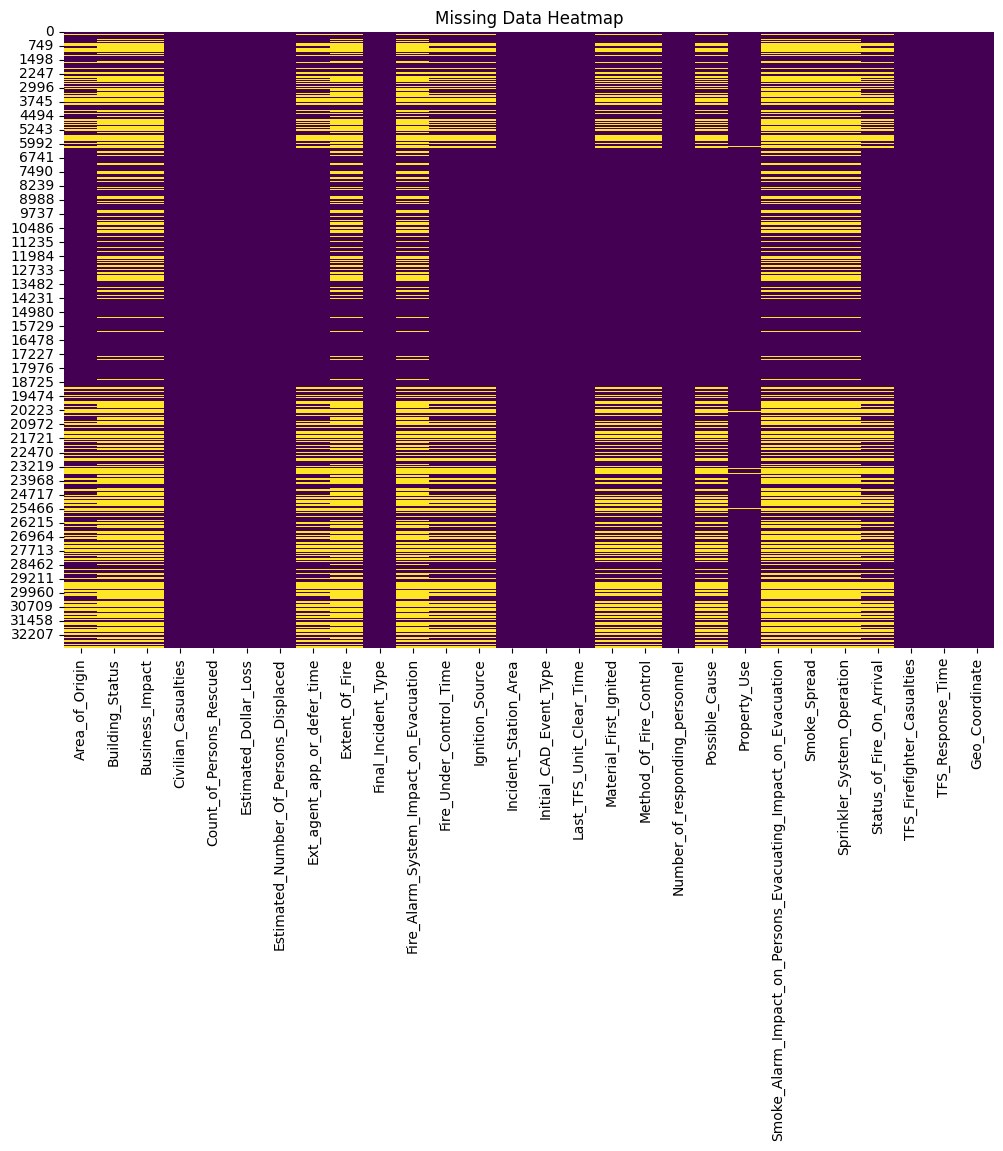

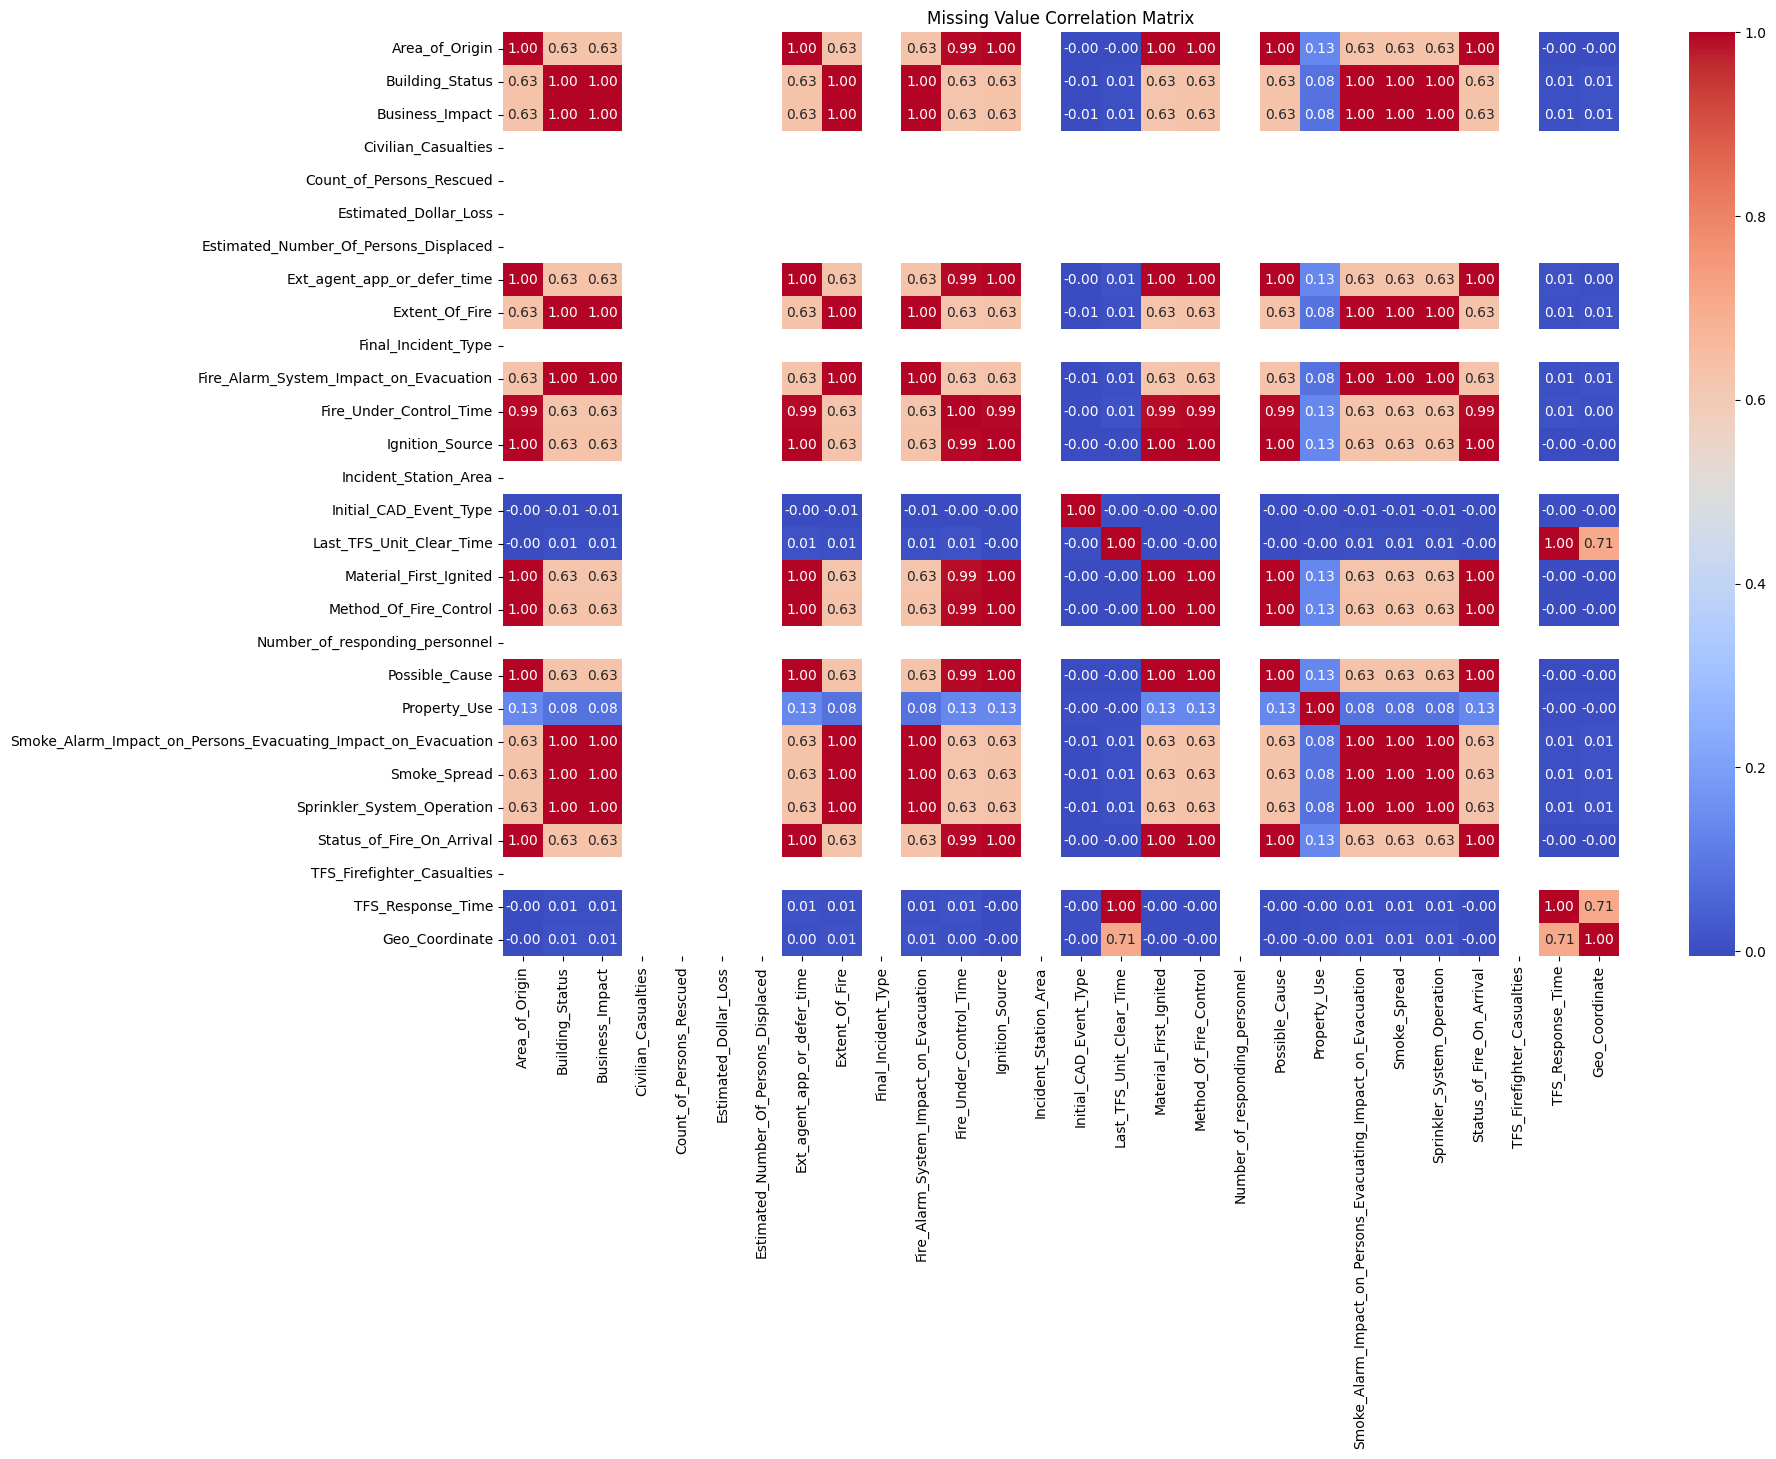

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

#heatmap to visualize missing data
plt.figure(figsize=(12, 8))
sns.heatmap(data_dropped.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

#missingness correlation matrix
missing_corr = data_dropped.isnull().corr()
plt.figure(figsize=(18, 12))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Missing Value Correlation Matrix')
plt.show()

## 2.2 Imputations! (MICE + KNN)

### Prepare the data for imputation

In [6]:
# from sklearn.experimental import enable_iterative_imputer  # Enable experimental feature
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.impute import IterativeImputer
# from sklearn.impute import KNNImputer
# from sklearn.preprocessing import MinMaxScaler

# # Step 1: Separate datetime columns and exclude from imputation
# datetime_columns = data_dropped.select_dtypes(include=['datetime64']).columns
# data_no_datetime = data_dropped.drop(columns=datetime_columns)

# # Step 2: Separate column types once
# numerical_cols = data_no_datetime.select_dtypes(include=['float64']).columns
# integer_cols = data_no_datetime.select_dtypes(include=['int64']).columns
# categorical_cols = data_no_datetime.select_dtypes(include=['object']).columns

# # Step 3: One-hot encode categorical columns
# encoder = OneHotEncoder(drop='first', sparse_output=True)
# categorical_encoded = encoder.fit_transform(data_no_datetime[categorical_cols]).toarray()
# categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# # Step 4: Combine all columns for imputation
# combined_data = pd.concat([data_no_datetime[numerical_cols], data_no_datetime[integer_cols], categorical_encoded_df], axis=1)

### MICE Imputation

### NOTE: ISSUE HERE! My kernal keeps crushing trying to run MICE Imputation. I suspect the issuse is the dataset is too big. Please try uncomment the code below and running it on your laptop!!!!!!

In [7]:
# # Apply MICE (IterativeImputer) imputation
# mice_imputer = IterativeImputer(max_iter=10, random_state=0)
# imputed_data = pd.DataFrame(mice_imputer.fit_transform(combined_data), columns=combined_data.columns)

# # Round integer columns
# imputed_data[integer_cols] = imputed_data[integer_cols].round().astype(int)

# # Decode categorical columns and reassemble final data
# imputed_categorical = pd.DataFrame(encoder.inverse_transform(imputed_data[categorical_encoded_df.columns]), columns=categorical_cols)
# data_final = pd.concat([imputed_data[numerical_cols], imputed_data[integer_cols], imputed_categorical], axis=1)

# # Reattach datetime columns and reorder
# data_final[datetime_columns] = data_dropped[datetime_columns]
# data_final = data_final[data_dropped.columns]

# data_final

### YOU CAN TEST IF YOUR LAPTOP RUNS THE CODE WITH 10% OF THE DATA

In [8]:
# sample_data = combined_data.sample(frac=0.1, random_state=1)  # Use 10% for quick testing

# mice_imputer = IterativeImputer(max_iter=10, random_state=0)
# imputed_data = pd.DataFrame(mice_imputer.fit_transform(sample_data), columns=sample_data.columns)

### KNN Imputation (K=40)

### NOTE: SAME ISSUE HERE! KNN Imputation crushes my kernal, so please try uncomment the code below and see if it runs on your laptop!

In [9]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Step 1: Separate datetime columns and exclude from imputation
datetime_columns = data_dropped.select_dtypes(include=['datetime64']).columns
data_no_datetime = data_dropped.drop(columns=datetime_columns)

# Step 2: Identify numerical and categorical columns
numerical_cols = data_no_datetime.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = data_no_datetime.select_dtypes(include=['object']).columns.tolist()

# Step 3: Impute numerical columns using KNNImputer
imputer = KNNImputer(n_neighbors=40)
numerical_data = data_no_datetime[numerical_cols]
imputed_numerical_data = pd.DataFrame(imputer.fit_transform(numerical_data), columns=numerical_cols)

# Step 4: Encode categorical columns using LabelEncoder
le_dict = {}
encoded_categorical_data = pd.DataFrame(index=data_no_datetime.index)

for col in categorical_cols:
    le = LabelEncoder()
    # Fit LabelEncoder on non-missing values
    non_missing = data_no_datetime[col].dropna()
    le.fit(non_missing)
    le_dict[col] = le
    # Transform data, assign -1 to missing values
    encoded_col = data_no_datetime[col].map(lambda s: le.transform([s])[0] if pd.notnull(s) else -1)
    encoded_categorical_data[col] = encoded_col

# Step 5: Combine imputed numerical data and encoded categorical data
combined_data = pd.concat([imputed_numerical_data, encoded_categorical_data], axis=1)

# Step 6: Impute categorical columns using KNeighborsClassifier
for col in categorical_cols:
    # Identify indices with missing values (-1)
    missing_idx = combined_data[combined_data[col] == -1].index
    non_missing_idx = combined_data[combined_data[col] != -1].index

    # Proceed only if there are missing values
    if len(missing_idx) > 0:
        # Features for training and predicting
        X_train = combined_data.loc[non_missing_idx].drop(columns=categorical_cols)
        y_train = combined_data.loc[non_missing_idx, col]
        X_test = combined_data.loc[missing_idx].drop(columns=categorical_cols)

        # Fit KNeighborsClassifier
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, y_train)

        # Predict missing values
        y_pred = knn.predict(X_test)

        # Fill missing values
        combined_data.loc[missing_idx, col] = y_pred

# Step 7: Inverse transform encoded categorical columns back to original categories
for col in categorical_cols:
    le = le_dict[col]
    combined_data[col] = combined_data[col].astype(int)
    # Map back to original categories, handle -1
    combined_data[col] = combined_data[col].map(lambda x: le.inverse_transform([x])[0] if x >= 0 else np.nan)

# Step 8: Reassemble final data
data_final = pd.concat(
    [combined_data[numerical_cols + categorical_cols], data_dropped[datetime_columns].reset_index(drop=True)],
    axis=1
)
data_final = data_final[data_dropped.columns]  # Ensure correct column order

# Display the final DataFrame
data_final


,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,...,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Status_of_Fire_On_Arrival,TFS_Firefighter_Casualties,TFS_Response_Time,Geo_Coordinate
0,81 - Engine Area,01 - Normal (no change),1 - No business interruption,0.0,0.0,15000.0,0.0,2018-02-24T21:12:00,1 - Confined to object of origin,01 - Fire,...,4.0,99 - Undetermined,"896 - Sidewalk, street, roadway, highway, hwy ...",7 - Not applicable: Occupant(s) first alerted ...,3 - Spread to entire room of origin,8 - Not applicable - no sprinkler system present,"7 - Fully involved (total structure, vehicle, ...",0.0,5.70,90.799686
1,"75 - Trash, rubbish area (outside)",01 - Normal (no change),8 - Not applicable (not a business),0.0,0.0,50.0,0.0,2018-02-24T21:29:42,1 - Confined to object of origin,01 - Fire,...,4.0,03 - Suspected Vandalism,"896 - Sidewalk, street, roadway, highway, hwy ...",1 - All persons (at risk of injury) self evacu...,2 - Confined to part of room/area of origin,8 - Not applicable - no sprinkler system present,2 - Fire with no evidence from street,0.0,4.80,90.654580
2,19 - Other Means of Egress,01 - Normal (no change),1 - No business interruption,0.0,0.0,0.0,0.0,2017-09-30T05:26:00,1 - Confined to object of origin,"03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vand...",...,22.0,Other Unintended Cause,891 - Outdoor general auto parking,"8 - Not applicable: No alarm, no persons present",2 - Confined to part of room/area of origin,8 - Not applicable - no sprinkler system present,1 - Fire extinguished prior to arrival,0.0,6.83,90.516573
3,"75 - Trash, rubbish area (outside)",01 - Normal (no change),1 - No business interruption,0.0,0.0,0.0,0.0,2018-02-25T14:19:25,1 - Confined to object of origin,01 - Fire,...,22.0,99 - Undetermined,511 - Department Store,"8 - Not applicable: No alarm, no persons present",99 - Undetermined,8 - Not applicable - no sprinkler system present,3 - Fire with smoke showing only - including v...,0.0,4.47,90.703965
4,"44 - Trash, Rubbish Storage (inc garbage chute...",01 - Normal (no change),1 - No business interruption,0.0,0.0,0.0,0.0,2016-04-23T11:33:04,1 - Confined to object of origin,"03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vand...",...,22.0,45 - Improperly Discarded,860 - Lawn around structure,7 - Not applicable: Occupant(s) first alerted ...,2 - Confined to part of room/area of origin,8 - Not applicable - no sprinkler system present,3 - Fire with smoke showing only - including v...,0.0,5.60,90.677966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32924,22 - Sleeping Area or Bedroom (inc. patients r...,01 - Normal (no change),1 - No business interruption,0.0,0.0,0.0,0.0,2023-01-01T07:29:02,1 - Confined to object of origin,01 - Fire,...,37.0,Misuse of ignition source/material ignited,231 - Shelter for displaced/abused persons,3 - No one (at risk) evacuated as a result of ...,3 - Spread to entire room of origin,4 - Other reason for non activation/operation,1 - Fire extinguished prior to arrival,0.0,5.20,90.685914
32925,64 - Porch or Balcony,01 - Normal (no change),8 - Not applicable (not a business),0.0,0.0,3000.0,0.0,2023-01-01T10:57:07,1 - Confined to object of origin,01 - Fire,...,38.0,Other Unintended Cause,323 - Multi-Unit Dwelling Over 12 Units,7 - Not applicable: Occupant(s) first alerted ...,9 - Confined to roof/exterior structure,8 - Not applicable - no sprinkler system present,4 - Flames showing from small area (one storey...,0.0,3.45,90.581461
32926,24 - Cooking Area or Kitchen,01 - Normal (no change),8 - Not applicable (not a business),0.0,0.0,1000.0,0.0,2023-01-01T12:28:05,1 - Confined to object of origin,01 - Fire,...,28.0,Design/Construction/Maintenance deficiency,301 - D

In [10]:
# from sklearn.experimental import enable_iterative_imputer  # Enable experimental feature
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.impute import KNNImputer
# from sklearn.preprocessing import MinMaxScaler
# import pandas as pd

# # Step 1: Separate datetime columns
# datetime_columns = data_dropped.select_dtypes(include=['datetime64']).columns
# data_no_datetime = data_dropped.drop(columns=datetime_columns)

# # Step 2: Separate column types
# numerical_cols = data_no_datetime.select_dtypes(include=['float64']).columns
# integer_cols = data_no_datetime.select_dtypes(include=['int64']).columns
# categorical_cols = data_no_datetime.select_dtypes(include=['object']).columns

# # Step 3: One-hot encode categorical columns
# encoder = OneHotEncoder(drop='first', sparse_output=False)
# categorical_encoded = encoder.fit_transform(data_no_datetime[categorical_cols])
# categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# # Step 4: Combine all columns for imputation
# combined_data = pd.concat([data_no_datetime[numerical_cols], data_no_datetime[integer_cols], categorical_encoded_df], axis=1)

# # Apply MinMax scaling for imputation
# scaler = MinMaxScaler()
# scaled_data = pd.DataFrame(scaler.fit_transform(combined_data), columns=combined_data.columns)

# # KNN imputation
# imputer = KNNImputer(n_neighbors=40)
# imputed_scaled_data = pd.DataFrame(imputer.fit_transform(scaled_data), columns=scaled_data.columns)

# # Inverse scaling and round integer columns
# imputed_data = pd.DataFrame(scaler.inverse_transform(imputed_scaled_data), columns=scaled_data.columns)
# imputed_data[integer_cols] = imputed_data[integer_cols].round().astype(int)

# # Decode categorical columns only on encoded columns
# imputed_categorical = pd.DataFrame(encoder.inverse_transform(imputed_data[categorical_encoded_df.columns]), columns=categorical_cols)

# # Drop encoded columns and replace with original categorical
# imputed_data = imputed_data.drop(columns=categorical_encoded_df.columns)
# data_final = pd.concat([imputed_data, imputed_categorical], axis=1)

# # Reattach datetime columns and reorder to match original data structure
# data_final[datetime_columns] = data_dropped[datetime_columns]
# data_final = data_final[data_dropped.columns]

# # Check if any NaN values remain
# print(data_final.isna().sum())

# data_final


### YOU CAN TEST IF YOUR LAPTOP RUNS THE CODE WITH 10% OF THE DATA

In [11]:
# scaled_data = pd.DataFrame(MinMaxScaler().fit_transform(combined_data), columns=combined_data.columns)
# sample_data = scaled_data.sample(frac=0.1, random_state=1)  # Use 10% for quick testing

# # KNN imputation
# imputed_scaled_data = pd.DataFrame(KNNImputer(n_neighbors=1).fit_transform(sample_data), columns=scaled_data.columns)

In [13]:
from IPython.display import FileLink
data_final.to_csv('Fire_Incidents_Data_Imputed.csv', index=False)  # index=False to avoid saving row indices
FileLink('Fire_Incidents_Data_Imputed.csv')

/content/Fire_Incidents_Data_Imputed.csv